1.	Consider a stock (ABC Corporation) currently trading at $46, with volatility of 40%.  The continuously compounded interest rate is 4%.   The stock does not pay dividends. 

a)	 Fill in the following table of data for 1 year options on ABC (based on the Black-Scholes Model, representing options on 1 share of stock).  Indicate what source you used for the data, so that I can double check if something looks funny:
Wrote a python notebook to calculate black Scholes.

Contract	Strike	Price
Call	45	8.54
Put	45	5.77
Call	50	6.48
Put	50	8.52
Call	55	4.87
Put	55	11.72
Call	60	3.64
Put	60	15.29


In [2]:

from scipy.stats import norm
import numpy as np
from numpy import log, sqrt, exp
import numpy as np
from matplotlib import pyplot as plt

def d1(S,K,T,r,dr,sigma):
    return(log(S/K)+(r-dr+sigma**2/2.)*T)/(sigma*sqrt(T))

def d2(S,K,T,r,dr,sigma):
    return d1(S,K,T,r,dr,sigma)-sigma*sqrt(T)

def bs_call(S,K,T,r,dr,sigma):
    return S*exp(-dr*T)*norm.cdf(d1(S,K,T,r,dr,sigma))-K*exp(-r*T)*norm.cdf(d2(S,K,T,r,dr,sigma))
  
def bs_put(S,K,T,r,dr,sigma):
    return K*exp(-r*T)-S*exp(-dr*T)+bs_call(S,K,T,r,dr,sigma)

strikes = [45,50,55,60]
print("Call\tStrike\tPut")
price = 46
volatility = .4
interest = .04
dividend = 0
for strike in strikes:
    print(f"{round(bs_call(price, strike,1,interest, dividend,volatility),2)}\t{strike}\t{round(bs_put(price, strike,1,interest,dividend,volatility),2)}")

Call	Strike	Put
8.54	45	5.77
6.48	50	8.52
4.87	55	11.72
3.64	60	15.29



ABC is the one company in the world developing a vaccine for M2022, a new, deadly, and highly contagious virus spread by mosquitoes.  XYZ Corporation is developing a targeted pesticide that kills the mosquitoes.  XYZ is going to need funding in one year to continue research and development.  XYZ management are nervous about the terms on which they will be able to raise equity. A banker suggests news that a strategy connected to the performance of ABC could be used to achieve the financing goals.

b.	 First, specify how you think XYZ’s outlook will correlate with movements in ABC stock.  Based on your view, discuss ways XYZ can hedge its risk using instruments tied to ABC.  Specifically, how can XYZ hedge using an ABC call?  An ABC put? An ABC forward? ABC stock?  In each case, discuss how ABC would use that instrument ALONE---not in combination with other derivatives. 

XYZ's outlook would be somewhat parallel to the performance of ABC's stock. As the disease propagates, there will be increased demand in solutions for it and investment will drive the solutions from private and public institutions- similar to what occurred with COVID19.

* XYZ can hedge upward movement of a stock with a call by allowing the purchaser of the option the right to purchase the asset at the strike in the future. If XYZ wants to speculate on the upward potential of ABC, they can purchase calls.
* XYZ can hedge downward movement in the stock by purchasing a put which gives XYZ the right to sell at the strike in the future.
* an ABC forward can lock in a price to buy or sell the ABC stock in the future.
* an ABC share gives XYZ the exposure to both upwards and downwards movements in the stock.

c.	The CEO of XYZ is initially skeptical because of the imperfect correlation between ABC’s stock performance and XYZ’s financing need.  But she has heard about spread positions and wants to learn more.  Would you recommend a bull spread or a bear spread on ABC stock?  

A bull spread would be the best option because the the bet is that the ABC stock will increase demand to protect against the disease.


d.	Based on your recommendation in (c), construct a spread of that type using the options from (a). Graph the profit in 1 year as a function of the price of ABC in one year.  Be sure to label the maximum profit, the minimum profit, and the breakeven point(s).

In [3]:
# 1.D

from functools import partial, cache
price = 46
volatility = .4
interest = .04
dividend = 0
ABC_Call = partial(bs_call,S=price,T=1,r=interest,dr=dividend,sigma=volatility)
ABC_Put = partial(bs_put,S=price,T=1,r=interest,dr=dividend,sigma=volatility)
LCall = lambda S, K: np.maximum(0, S-K)
LPut = lambda S, K: np.maximum(0, K-S)
SCall =  lambda S, K: np.minimum(0, K-S)
SPut =  lambda S, K: np.minimum(0, S-K)
LForward = lambda S, K: S-K
SForward = lambda S, K: K-S

price_bet = price * ( 1 + interest)
print(f"Forward Rate for Stock {price_bet}")

def bull_spread_payoff(Spot, Kc, Kc2):
    long_call = partial(LCall, K = Kc)
    short_call = partial(SCall, K = Kc2)
    spread = lambda Price:  long_call(Price) + short_call(Price)
    return  np.array(list(map(spread, Spot.tolist())))

def bull_spread_profit(Spot, Kc, Kc2):
    long_call_price = ABC_Call(K=Kc)
    short_call_price = ABC_Call(K=Kc2)
   
    return bull_spread_payoff(Spot, Kc, Kc2) - long_call_price + short_call_price

Spots = np.linspace(0, 2*price, 10000)

Forward Rate for Stock 47.84


In [4]:


def plot_derivative(dfunc, Spots, title="profit", payprof = True):
    fig, ax = plt.subplots()

    ax.set_title(title)
    def zero(arry):
        closest = arry[0]
        closest_idx = 0
        for idx, val in enumerate(arry):
            if np.abs(val) < np.abs(closest):
                closest_idx = idx
                closest = val
        return [closest, closest_idx]
    val, idx = zero(dfunc)
    print(Spots[idx])
    ax.plot(Spots, dfunc)
    ax.plot(Spots[idx], val,"ro")# f"Break Even ${round(Spots[idx],2)}")
    ax.plot(Spots[dfunc == np.min(dfunc)], dfunc[dfunc == np.min(dfunc)])
    ax.plot(Spots[dfunc == np.max(dfunc)], dfunc[dfunc == np.max(dfunc)])
    ax.grid(True, which='both')

    # set the x-spine (see below for more info on `set_position`)
    ax.spines['left'].set_position('zero')
    ax.set_ylim(np.min(dfunc), max(dfunc))
    # turn off the right spine/ticks
    ax.spines['right'].set_color('none')
    ax.yaxis.tick_left()

    # set the y-spine
    ax.spines['bottom'].set_position('zero')

    # turn off the top spine/ticks
    ax.spines['top'].set_color('none')
    ax.xaxis.tick_bottom()
    flag = "profit" if payprof else "payoff"
    ax.legend([
        f"Derivative {flag}", 
        f"Break Even Point: ${round(Spots[idx],2)}",
        f"Minimum {flag} ${round(np.min(dfunc),2)}",
        f"Maximum {flag} ${round(np.max(dfunc),2)}"
        ])
    ax.set_ylabel("Profit $")


    

48.66366636663666


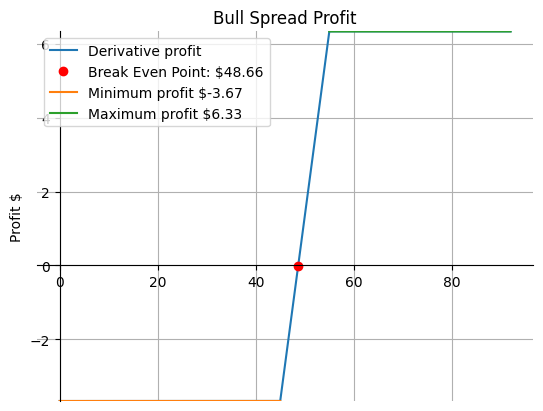

In [5]:
plot_derivative(bull_spread_profit(Spots, 45, 55), Spots, title="Bull Spread Profit")

2.	Just as Times Mirror is about to agree to the PEPS transaction, Congress passes a sweeping tax reform of the rules on constructive sales, and Morgan Stanley must return to the drawing board to design a new security that will enable Times Mirror to reduce its exposure to Netscape without incurring capital gains taxes.  Morgan Stanley proposes a new security, PEPS II, which obligates Times Mirror to deliver:
a.	 cash equal to the price of one share of Netscape in two years if the price of Netscape is below 25.
b.	If the price is between $25 and $50, Times Mirror must deliver $25  
c.	If the price is greater than $50 but below $70, Times Mirror must deliver cash equal to 0.5 shares of Netscape.  
d.	If the price is greater than or equal to $70, Times Mirror must deliver $35
e.	In addition, Times Mirror must pay a $4 coupon at the end of one year and at maturity (at the end of two years).  Assume the current price of Netscape is $40, ignore any credit risk of Times Mirror, assume that Netscape will not pay dividends, assume that the continuously compounded interest rate is 5%, and volatility is 90%.


0.0


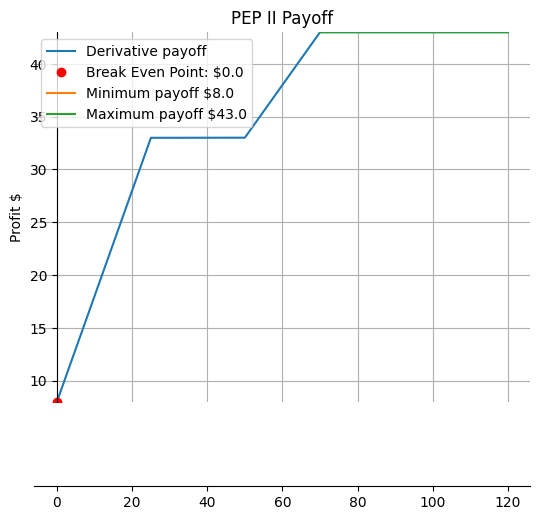

In [6]:
volatility2 = .9
interest2 = 0.05
NS_price = 40
NS_coupon = 4

def PEP2(Spots: np.array):
    profit = np.zeros(Spots.shape)
    profit[Spots <= 25]=Spots[Spots <= 25]
    profit[(Spots > 25)&(Spots < 50)] = 25
    profit[(Spots >= 50)&(Spots < 70)] = 0.5*Spots[(Spots >= 50)&(Spots < 70)]
    profit[Spots >= 70 ] = 35
    profit += NS_coupon * 2
    return profit

Spots = np.linspace(0, NS_price *3, 10000)
plot_derivative(PEP2(Spots), Spots, title="PEP II Payoff", payprof = False)


    
    


0.0


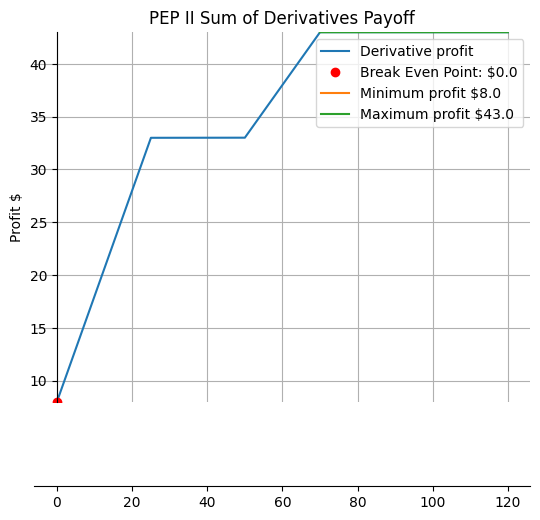

In [7]:
def PEP2Derivatives(Spots: np.array):
    profit = np.zeros(Spots.shape)
    profit += Spots  + SCall(Spots, K=25)
    profit += 0.5 * LCall(Spots, K=50)
    profit += 0.5 * SCall(Spots, K=70)
    profit += 2 * NS_coupon
    
    return profit
plot_derivative(PEP2Derivatives(Spots), Spots, title="PEP II Sum of Derivatives Payoff",payprof = False)
    
    

In [8]:
SCall25 = bs_call(NS_price, 25, 2, interest2, 0, volatility2)
LCall50 = -bs_call(NS_price, 50, 2, interest2, 0, volatility2)
SCall70 = bs_call(NS_price, 70, 2, interest2, 0, volatility2)




25.01050105010501


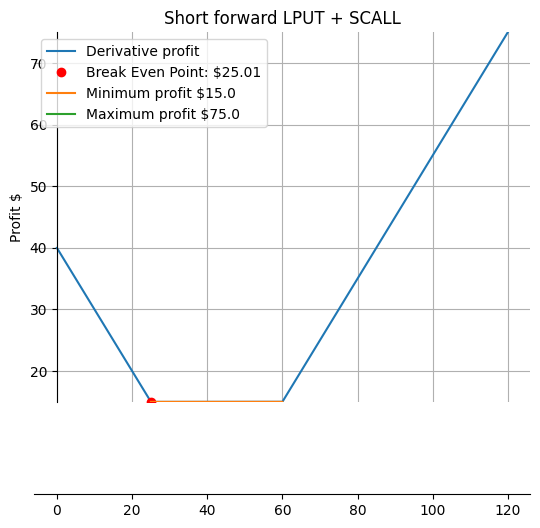

In [9]:
plot_derivative(LPut(Spots, K=25) + LCall(Spots, K=60)  + LForward(Spots, K=25) + SForward(Spots, K=40), Spots, title="Short forward LPUT + SCALL")

In [10]:
bs_put(40, 100, 1, 0.06, 0, 0.45) 

54.47361120551098

0.0


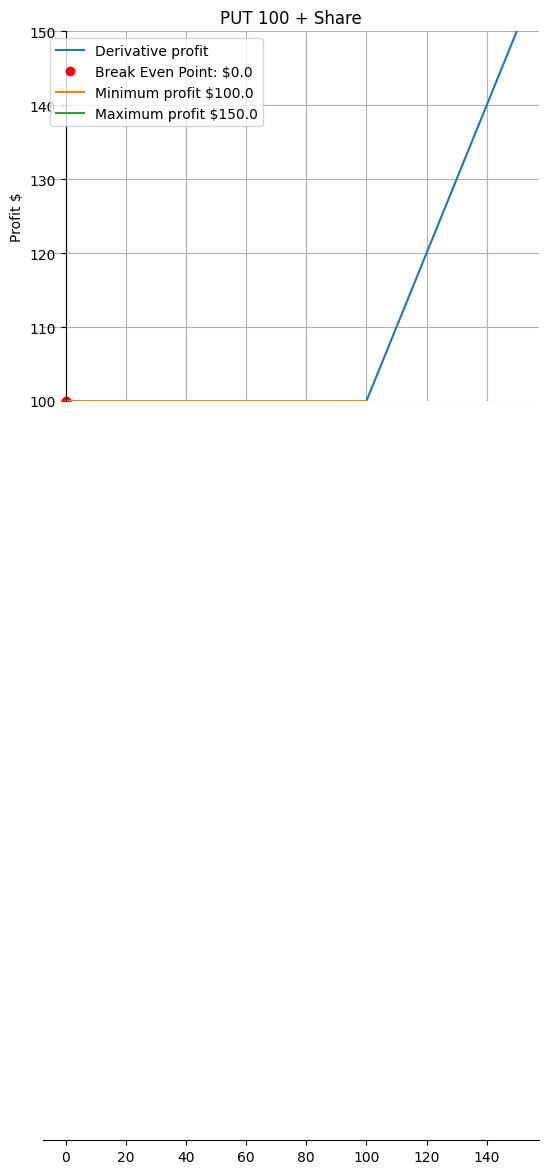

In [11]:
plot_derivative(np.linspace(0, 150, 1000) + LPut(np.linspace(0, 150, 1000), K=100), np.linspace(0, 150, 1000), title="PUT 100 + Share")